# Time series - multivariate prediction, LSTM for continuous prediction

In this example we will load prepared data and try to predict it with a lstm network producing continuous prediction

This example is very similar to the last lstm example except the model is trained to predict one step into the future that can be used for latter predictions.

In [2]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import os
from datetime import date
import re

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_rows = 30
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
PATH = '/content/drive/My Drive/ml-college/time-series-analysis/data/weather/ts_temp_dp_press.p'
training_df = pd.read_pickle(PATH)

Notice that we would randomly sample the training data from the whole weather history.

The `indices` array will contain starting date for each sample

In [0]:
import random

PREDICTION_LEN = 7
HISTORY_LEN = 14
NUM_SAMPLES = 2000
NUM_INPUTS = len(training_df.columns)

indices = random.sample(range(0,len(training_df) - HISTORY_LEN - 1), NUM_SAMPLES)

In this example the target sequence is shifted one step into the future. The model need to accumulate information in its inner state to correctly predict it.

Both input and output tensors remain in sequence form.

In [0]:
ts_data = training_df.values
ts_inputs = np.array([ts_data[i:i + HISTORY_LEN] for i in indices])
ts_outputs = np.array([ts_data[i + 1: i + 1 + HISTORY_LEN] for i in indices])

In [37]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, GRU, Input, Dense

inputs = Input(shape=ts_inputs.shape[1:])
x = GRU(64, return_sequences=True, recurrent_activation='sigmoid')(inputs)
x = GRU(32, return_sequences=True, recurrent_activation='sigmoid')(x)
outputs = Dense(NUM_INPUTS)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 14, 4)]           0         
_________________________________________________________________
gru_22 (GRU)                 (None, 14, 64)            13440     
_________________________________________________________________
gru_23 (GRU)                 (None, 14, 32)            9408      
_________________________________________________________________
dense_20 (Dense)             (None, 14, 4)             132       
Total params: 22,980
Trainable params: 22,980
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(ts_inputs, ts_outputs, validation_split=0.1, epochs=100)

Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 5s 3ms/sample - loss: 0.1123 - val_loss: 0.0757
Epoch 2/100
1800/1800 [==============================] - 1s 356us/sample - loss: 0.0665 - val_loss: 0.0631
Epoch 3/100
1800/1800 [==============================] - 1s 365us/sample - loss: 0.0586 - val_loss: 0.0588
Epoch 4/100
1800/1800 [==============================] - 1s 352us/sample - loss: 0.0558 - val_loss: 0.0570
Epoch 5/100
1800/1800 [==============================] - 1s 361us/sample - loss: 0.0544 - val_loss: 0.0559
Epoch 6/100
1800/1800 [==============================] - 1s 362us/sample - loss: 0.0535 - val_loss: 0.0552
Epoch 7/100
1800/1800 [==============================] - 1s 351us/sample - loss: 0.0529 - val_loss: 0.0546
Epoch 8/100
1800/1800 [==============================] - 1s 365us/sample - loss: 0.0526 - val_loss: 0.0542
Epoch 9/100
1800/1800 [==============================] - 1s 353us/sample - loss: 0.0520 - val_loss:

In [0]:
model.save_weights('model_plus1_predition.h5')

In [40]:
inputs = Input(batch_shape=(1, 1, NUM_INPUTS))
x = GRU(64, return_sequences=True, stateful=True)(inputs)
x = GRU(32, return_sequences=True, stateful=True)(x)
outputs = Dense(NUM_INPUTS)(x)

pred_model = Model(inputs, outputs)
pred_model.summary()
pred_model.load_weights('model_plus1_predition.h5')

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(1, 1, 4)]               0         
_________________________________________________________________
gru_24 (GRU)                 (1, 1, 64)                13440     
_________________________________________________________________
gru_25 (GRU)                 (1, 1, 32)                9408      
_________________________________________________________________
dense_21 (Dense)             (1, 1, 4)                 132       
Total params: 22,980
Trainable params: 22,980
Non-trainable params: 0
_________________________________________________________________


## Prediction phase

To test the prediction, we will take a particular date and feed the history into the network.

The network will predict one step into the future and we will take this prediction and feed it back to the network. In this way, we can predict multiple (and variable) steps into the future

Notice that the model is `stateful` i.e. the hidden state does not reset after the prediction.

In [0]:
import datetime
from datetime import timedelta

In [0]:
prediction_date = date(2014, 12, 23)

prediction_input = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date]

pred_model.reset_states()
for i in range(0, HISTORY_LEN):
    prediction = pred_model.predict(prediction_input.values[i].reshape(1, 1, NUM_INPUTS))
    
self_predicition = [np.copy(prediction)]

for i in range(0, PREDICTION_LEN - 1):
    prediction = pred_model.predict(self_predicition[i])
    self_predicition.append(np.copy(prediction))
    


history = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date + timedelta(days=PREDICTION_LEN)]
prediction_df = pd.DataFrame(np.vstack(self_predicition).reshape((PREDICTION_LEN, NUM_INPUTS)), index=pd.date_range(start=prediction_date + timedelta(days=1), freq='D', periods=PREDICTION_LEN))


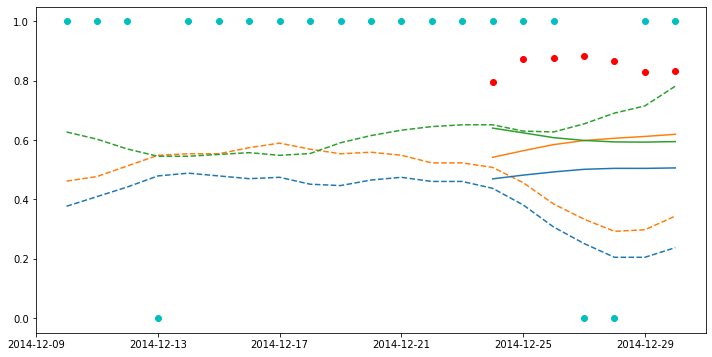

In [45]:
plt.figure(figsize = (12, 6))
history_plt = plt.plot(history.iloc[:,0:3], linestyle='--')
plt.plot(history.iloc[:,3], 'oc')
plt.plot(prediction_df.iloc[:,0], color=history_plt[0].get_color())
plt.plot(prediction_df.iloc[:,1], color=history_plt[1].get_color())
plt.plot(prediction_df.iloc[:,2], color=history_plt[2].get_color())
plt.plot(prediction_df.iloc[:,3], 'or')
plt.show()

## Multiple loss functions

To cirrectly handle this example, we should be training the network with multiple loss fuctions as prediction of precipitation is a binary classification task.

In [10]:
ts_outputs_1 = np.array([ts_data[i + 1: i + 1 + HISTORY_LEN, 0:3] for i in indices])
ts_outputs_2 = np.array([ts_data[i + 1: i + 1 + HISTORY_LEN, 3] for i in indices])

print(ts_outputs_1.shape)
print(ts_outputs_2.shape)

(2000, 14, 3)
(2000, 14)


In [25]:
inputs = Input(shape=ts_inputs.shape[1:])
x = GRU(64, return_sequences=True, recurrent_activation='sigmoid')(inputs)
x = GRU(32, return_sequences=True, recurrent_activation='sigmoid')(x)
outputs_1 = Dense(3)(x)
outputs_2 = Dense(1, activation="sigmoid")(x)

model = Model(inputs, [outputs_1, outputs_2])
model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 14, 4)]      0                                            
__________________________________________________________________________________________________
gru_16 (GRU)                    (None, 14, 64)       13440       input_9[0][0]                    
__________________________________________________________________________________________________
gru_17 (GRU)                    (None, 14, 32)       9408        gru_16[0][0]                     
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 14, 3)        99          gru_17[0][0]                     
____________________________________________________________________________________________

In [26]:
model.fit(ts_inputs, [ts_outputs_1, ts_outputs_2], validation_split=0.1, epochs=100)

Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 5s 3ms/sample - loss: 0.7351 - dense_15_loss: 0.0688 - dense_16_loss: 0.6659 - val_loss: 0.6822 - val_dense_15_loss: 0.0245 - val_dense_16_loss: 0.6625
Epoch 2/100
1800/1800 [==============================] - 1s 419us/sample - loss: 0.6495 - dense_15_loss: 0.0160 - dense_16_loss: 0.6326 - val_loss: 0.6494 - val_dense_15_loss: 0.0098 - val_dense_16_loss: 0.6462
Epoch 3/100
1800/1800 [==============================] - 1s 412us/sample - loss: 0.6252 - dense_15_loss: 0.0076 - dense_16_loss: 0.6175 - val_loss: 0.6395 - val_dense_15_loss: 0.0073 - val_dense_16_loss: 0.6399
Epoch 4/100
1800/1800 [==============================] - 1s 432us/sample - loss: 0.6170 - dense_15_loss: 0.0051 - dense_16_loss: 0.6111 - val_loss: 0.6332 - val_dense_15_loss: 0.0036 - val_dense_16_loss: 0.6378
Epoch 5/100
1800/1800 [==============================] - 1s 444us/sample - loss: 0.6106 - dense_15_loss: 0.0033

In [0]:
model.save_weights('model_plus1_mult_predition.h5')

In [46]:
inputs = Input(batch_shape=(1, 1, NUM_INPUTS))
x = GRU(64, return_sequences=True, stateful=True)(inputs)
x = GRU(32, return_sequences=True, stateful=True)(x)
outputs_1 = Dense(3)(x)
outputs_2 = Dense(1, activation='sigmoid')(x)

pred_model = Model(inputs, [outputs_1, outputs_2])
pred_model.summary()
pred_model.load_weights('model_plus1_mult_predition.h5')

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(1, 1, 4)]          0                                            
__________________________________________________________________________________________________
gru_26 (GRU)                    (1, 1, 64)           13440       input_14[0][0]                   
__________________________________________________________________________________________________
gru_27 (GRU)                    (1, 1, 32)           9408        gru_26[0][0]                     
__________________________________________________________________________________________________
dense_22 (Dense)                (1, 1, 3)            99          gru_27[0][0]                     
___________________________________________________________________________________________

In [0]:
prediction_date = date(2014, 12, 23)

prediction_input = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date]

pred_model.reset_states()
for i in range(0, HISTORY_LEN):
    prediction_1, prediction_2 = pred_model.predict(prediction_input.values[i].reshape(1, 1, NUM_INPUTS))

self_predicition = [np.concatenate((prediction_1, prediction_2), axis=-1)]

for i in range(0, PREDICTION_LEN - 1):
    prediction_1, prediction_2 = pred_model.predict(self_predicition[i])

    self_predicition.append(np.concatenate((prediction_1, prediction_2), axis=-1))
    


history = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date + timedelta(days=PREDICTION_LEN)]
prediction_df = pd.DataFrame(np.vstack(self_predicition).reshape((PREDICTION_LEN, NUM_INPUTS)), index=pd.date_range(start=prediction_date + timedelta(days=1), freq='D', periods=PREDICTION_LEN))


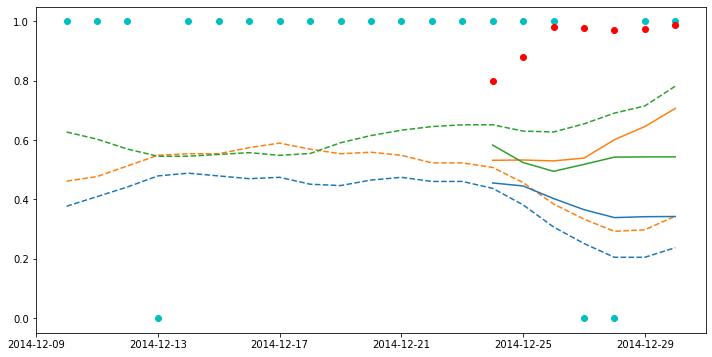

In [50]:
plt.figure(figsize = (12, 6))
history_plt = plt.plot(history.iloc[:,0:3], linestyle='--')
plt.plot(history.iloc[:,3], 'oc')
plt.plot(prediction_df.iloc[:,0], color=history_plt[0].get_color())
plt.plot(prediction_df.iloc[:,1], color=history_plt[1].get_color())
plt.plot(prediction_df.iloc[:,2], color=history_plt[2].get_color())
plt.plot(prediction_df.iloc[:,3], 'or')
plt.show()